In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
from plotly import graph_objects as go

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month',creation_date) AS month_date,
       SUM (views_count) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('year',creation_date) BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY month_date
ORDER BY total_views DESC;
'''

# выполните запрос
total_views = pd.read_sql_query(query, con=engine) 

In [7]:
total_views

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


<details>

<summary>Подсказка</summary>

Используйте функцию для усечения даты, а затем сгруппируйте и отсортируйте данные.
</details>

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

In [8]:
# напишите ваш ответ здесь
# Наибольшее количество просмотров постов - осенью, наименьшее - летом (июль, август). 
# Такое различие может быть связано с актуальностью тем постов именно в осенний период 
#(возможно темы постов - школа, универстет, налоговая отчетность и т.п)

# Задание 2

Выведите список имён самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name |
| ------------ |
| 1800 INFORMATION |
| Adam Bellaire |
| Adam Davis |
| ... |

In [9]:
# напишите запрос
query = '''
WITH filtr AS (SELECT u.id,
                      u.display_name,
                      u.creation_date AS data_reg,
                      u.creation_date+ INTERVAL '1 MONTH' AS new_date
               FROM stackoverflow.users u),
filtr2 AS (               
SELECT filtr.display_name,
      COUNT(p.id) AS count_answer
FROM stackoverflow.posts p
JOIN stackoverflow.post_types pt ON p.post_type_id=pt.id
JOIN filtr ON filtr.id=p.user_id
WHERE pt.type='Answer' AND (creation_date BETWEEN data_reg AND new_date)
GROUP BY filtr.display_name)
SELECT display_name
FROM filtr2
WHERE count_answer>100
ORDER BY display_name
'''
# выполните запрос
display_name = pd.read_sql_query(query, con=engine) 

In [10]:
display_name.head(10)

,display_name
0,1800 INFORMATION
1,Adam Bellaire
2,Adam Davis
3,Adam Liss
4,Alan
5,Amy B
6,Ben Hoffstein
7,Brian
8,Cade Roux
9,CesarB


<details>

<summary>Подсказка</summary>

Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово `INTERVAL`, например, так: `<дата> + INTERVAL '1 year 2 months 3 days'`.</details>

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 182984 |
| ... | ... |

In [11]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month',p.creation_date) AS month_date,
       COUNT (p.views_count) AS total_views
FROM stackoverflow.posts p
WHERE p.user_id IN (SELECT u.id AS filtr_id
                    FROM stackoverflow.users u
                    RIGHT JOIN stackoverflow.posts p ON u.id=p.user_id
                    WHERE (CAST(DATE_TRUNC ('month', u.creation_date) AS date) = '2008-09-01')
                    AND (CAST(DATE_TRUNC ('month', p.creation_date) AS date) = '2008-12-01')) 
GROUP BY month_date                    
ORDER BY month_date DESC;
'''

# выполните запрос
tab=pd.read_sql_query(query, con=engine) 

In [12]:
tab

,month_date,total_views
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


<details>

<summary>Подсказка</summary>

Сначала найдите идентификаторы пользователей, которые зарегистрировались в сентябре 2008 года и оставили хотя бы один пост в декабре. Затем используйте результат для среза и посчитайте посты по месяцам.</details>

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

In [13]:
# напишите ваш ответ здесь
# Аномально то, что в выборку, зарегистрировавшихся пользователей в сентябре, попали посты августа. 
#Возможно, если постом считается ответ на вопрос, то пользователь мог не регистрироваться

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [14]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS views_cum
FROM stackoverflow.posts p   
ORDER BY user_id, creation_date
'''

# выполните запрос
views_cum=pd.read_sql_query(query, con=engine) 

In [15]:
views_cum

,user_id,creation_date,views_count,views_cum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


<details>

<summary>Подсказка</summary>

Для подсчёта суммы с накоплением используйте оконную функцию.
</details>

# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.8076923076923077 |
| 234     | 5.3043478260869565 |
| ...     | ... |

In [16]:
# напишите запрос
query = '''
WITH id_top AS (SELECT p.user_id,
                       COUNT(p.id) AS post_count
                FROM stackoverflow.posts p  
                WHERE DATE_TRUNC('month', p.creation_date):: date = '2008-08-01' 
                GROUP BY 1
                HAVING COUNT(p.id)>120),
days_top AS (SELECT p.user_id,
                    COUNT(DISTINCT DATE_TRUNC('days',p.creation_date)::date) AS days_post
             FROM stackoverflow.posts p  
             WHERE DATE_TRUNC('month', p.creation_date):: date = '2008-08-01' 
             GROUP BY 1)
SELECT days_top.user_id,
        (post_count::float/days_post::float) avg_daily
FROM days_top
JOIN id_top  ON id_top.user_id=days_top.user_id
ORDER BY avg_daily

                
'''

# выполните запрос
avg_daily=pd.read_sql_query(query, con=engine)

In [17]:
avg_daily

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


<details>

<summary>Подсказка</summary>

Сначала найдите идентификаторы пользователей, которые написали более 120 постов за август. Используя этот запрос в качестве подзапроса для среза, найдите и сохраните во временную таблицу идентификаторы нужных пользователей, дни августа и количество постов в день. В основном запросе сгруппируйте данные по пользователям и найдите для каждого из них среднее количество постов.
</details>

# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [18]:
# напишите запрос
query = '''
SELECT ROUND(AVG(count_number)) AS result
FROM (SELECT user_id,
             COUNT(DISTINCT(DATE_TRUNC('day', creation_date))) AS count_number
      FROM stackoverflow.posts 
      WHERE (DATE_TRUNC('day', creation_date))>='2008-12-01' AND
      (DATE_TRUNC('day', creation_date))<='2008-12-07'
      GROUP BY user_id) AS t1
'''

# выполните запрос
result=pd.read_sql_query(query, con=engine)

In [19]:
result

,result
0,2.0


<details>

<summary>Подсказка</summary>

Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

Проанализируйте итоговую таблицу — какие выводы можно сделать?

In [20]:
# напишите ваш ответ здесь
# в среднем в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой 2 раза 

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | NULL |
| 1       | 2008-07-31 23:55:38 | NULL |
| 1       | 2008-07-31 23:56:41 | Июль |
| 1       | 2008-08-04 02:45:08 | Июль |
| 1       | 2008-08-04 04:31:03 | Июль |
| 1       | 2008-08-04 08:04:42 | Август |
| ... | ... | ... |

In [21]:
# напишите запрос
query = '''
WITH tb AS (
SELECT user_id,
       creation_date,
       LAG(creation_date,2,NULL) OVER(PARTITION BY user_id ORDER BY creation_date) AS second_last_month
FROM stackoverflow.posts 
ORDER BY user_id, creation_date)
SELECT user_id,
       creation_date,
       CASE
           WHEN EXTRACT(MONTH FROM second_last_month)=1 THEN 'Январь'
           WHEN EXTRACT(MONTH FROM second_last_month)=2 THEN 'Февраль'
           WHEN EXTRACT(MONTH FROM second_last_month)=3 THEN 'Март'
           WHEN EXTRACT(MONTH FROM second_last_month)=4 THEN 'Апрель'
           WHEN EXTRACT(MONTH FROM second_last_month)=5 THEN 'Май'
           WHEN EXTRACT(MONTH FROM second_last_month)=6 THEN 'Июнь'
           WHEN EXTRACT(MONTH FROM second_last_month)=7 THEN 'Июль'
           WHEN EXTRACT(MONTH FROM second_last_month)=8 THEN 'Август'
           WHEN EXTRACT(MONTH FROM second_last_month)=9 THEN 'Сентябрь'
           WHEN EXTRACT(MONTH FROM second_last_month)=10 THEN 'Октябрь'
           WHEN EXTRACT(MONTH FROM second_last_month)=11 THEN 'Ноябрь'
           WHEN EXTRACT(MONTH FROM second_last_month)=12 THEN 'Декабрь'
       END    
FROM tb
'''

# выполните запрос
second_last_month=pd.read_sql_query(query, con=engine)

In [22]:
second_last_month.head(10)

,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,Июль
3,1,2008-08-04 02:45:08,Июль
4,1,2008-08-04 04:31:03,Июль
5,1,2008-08-04 08:04:42,Август
6,1,2008-08-10 08:28:52,Август
7,1,2008-08-11 19:23:47,Август
8,1,2008-08-12 00:30:43,Август
9,1,2008-08-12 04:59:35,Август


<details>

<summary>Подсказка</summary>

Преобразовать результат оконной функции в нужное значение вам поможет аналог условного оператора в SQL: `CASE <поле> WHEN <старое значение> THEN <новое значение> END`.
</details>

# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --------- | ------------ | --------- | ---------------- | -------------- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 | 
| ... | ... | ... | ... | ... |

In [23]:
# напишите запрос
query = '''
WITH profile AS
  (SELECT u.id,
          DATE_TRUNC('month', MIN(p.creation_date))::date AS date_first_post
   FROM stackoverflow.users u
   JOIN stackoverflow.posts p ON u.id = p.user_id
   GROUP BY 1),
sessions AS   
    (SELECT profile.date_first_post,
            DATE_TRUNC('month',p.creation_date)::date AS date_post,
            COUNT(DISTINCT(profile.id)) AS users_cnt
     FROM stackoverflow.posts p
     JOIN profile ON profile.id=p.user_id
     GROUP BY profile.date_first_post, DATE_TRUNC('month',p.creation_date)::date),
cohort AS      
    (SELECT COUNT(DISTINCT(profile.id)) AS cohort_size,
            profile.date_first_post AS date_cohort     
     FROM stackoverflow.posts p
     JOIN profile ON profile.id=p.user_id
     GROUP BY profile.date_first_post)    
SELECT cohort.date_cohort AS cohort_dt,
       sessions.date_post AS session_date,
       sessions.users_cnt,
       cohort.cohort_size AS cohort_users_cnt,
       ROUND(sessions.users_cnt *100.0/cohort.cohort_size,2) AS retention_rate
FROM sessions
JOIN cohort ON sessions.date_first_post=cohort.date_cohort

'''

# выполните запрос
retention_rate=pd.read_sql_query(query, con=engine)

In [24]:
retention_rate

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


<details>

<summary>Подсказка</summary>

Вспомните, как выглядел запрос для расчёта Retention Rate в теории. Создайте две временные таблицы: `profile` и `sessions` (в ней будет информация о публикациях), а затем используйте их в основном запросе.

Во временной таблице `profile` вам понадобятся три поля:
- идентификатор пользователя;
- дата первого поста пользователя, усечённая до месяца (признак начала когорты);
- количество пользователей этой когорты.
</details>

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [25]:
# постройте тепловую карту Retention Rate

In [26]:
retention_rate_pivot=retention_rate.pivot_table(
    index='cohort_dt',
    columns='session_date',
    values='retention_rate',
) 


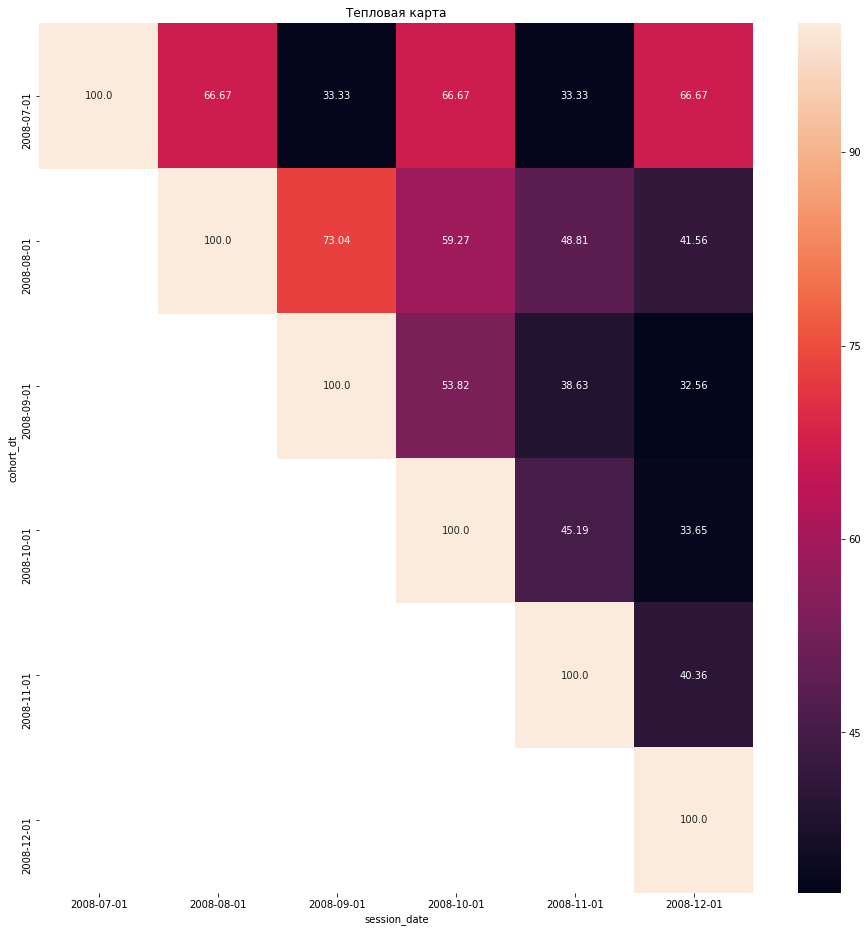

In [27]:
# строим хитмэп

plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention_rate_pivot, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()

In [28]:
# опишите аномалии или другие необычные явления и сформулируйте гипотезы 
#Удержание первой когорты не убывает по экспоненциальному закону, оно растет на 3ом и 5ом лайфтайме
#Скорее всего, ошибка в исходных данных

# Задание 9

На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | NULL |
| 10 | 63102 | -11 |
| ... | ... | ... |

In [29]:
# напишите запрос
query = '''
WITH VV AS (
SELECT CAST(DATE_TRUNC('month', creation_date) AS date) AS creation_month,
       COUNT(id) AS posts_count
FROM stackoverflow.posts    
WHERE DATE_TRUNC('day', creation_date) BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY 1) 
SELECT *,
        ROUND(((LAG(posts_count) OVER()-posts_count::numeric) /LAG(posts_count) OVER())*100,2) AS percentage
FROM VV
'''

# выполните запрос
percentage=pd.read_sql_query(query, con=engine)

In [30]:
percentage

,creation_month,posts_count,percentage
0,2008-09-01,70371,NaN
1,2008-10-01,63102,10.33
2,2008-11-01,46975,25.56
3,2008-12-01,44592,5.07


<details>

<summary>Подсказка</summary>

Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.
</details>

Постройте круговую диаграмму с количеством постов по месяцам.

In [31]:
# постройте круговую диаграмму с количеством постов по месяцам

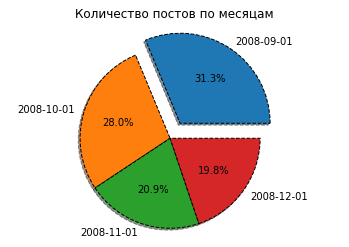

In [32]:
vals = percentage['posts_count']
labels = percentage['creation_month']
myexp = [0.2, 0, 0, 0]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True,explode = myexp, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"})
ax.axis("equal")
plt.title("Количество постов по месяцам");

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [33]:
# напишите запрос
query = '''
WITH last AS(
SELECT EXTRACT(WEEK FROM creation_date) AS week_creation,
       LAST_VALUE(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date) ORDER BY creation_date ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) AS creation_date
FROM stackoverflow.posts
WHERE user_id IN (
    SELECT user_id
    FROM stackoverflow.posts 
    GROUP BY 1
    ORDER BY COUNT(id) DESC
    LIMIT 1) AND DATE_TRUNC('month',creation_date)='2008-10-01')
SELECT *
FROM last
GROUP BY 1,2
ORDER BY 1
'''

# выполните запрос
top_user=pd.read_sql_query(query, con=engine)

In [34]:
top_user

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


<details>

<summary>Подсказка</summary>

Декомпозируйте задачу:
- Найдите пользователя, который опубликовал больше всего постов.
- Найдите дату и время создания каждого поста этого пользователя и номер недели.
- Отобразите данные только о последних постах пользователя. Для этого можно использовать оконную функцию.
</details>